In [1]:
# 这个notebook通过举例，解释SparseMMoE.py中各部分
# 这个版本为了简化，实现的是SparseMoE，而非SparseMMoE，即没有考虑多任务学习
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
import numpy as np

In [2]:
class Expert(nn.Module):
    def __init__(self, input_dim, output_dim, expert_dropout):  # input_dim代表输入维度，output_dim代表输出维度
        super(Expert, self).__init__()

        expert_hidden_layers = [64, 32]
        self.expert_layer = nn.Sequential(
            nn.Linear(input_dim, expert_hidden_layers[0]),
            nn.ReLU(),
            nn.Linear(expert_hidden_layers[0], expert_hidden_layers[1]),
            nn.ReLU(),
            nn.Linear(expert_hidden_layers[1], output_dim),
            nn.ReLU(),
            nn.Dropout(expert_dropout)
        )

    def forward(self, x):
        out = self.expert_layer(x)
        return out

# Dispatcher

In [3]:
class Dispatcher(object):
    # gates是一个(batch_size,num_experts)的张量，表示batch内数据在各expert上的权重
    def __init__(self, num_experts, gates):
        self.gates = gates
        self.num_experts = num_experts

        nonzero_gates_index = torch.nonzero(gates)

        # nonzero_gates_index的第二列表示expert的下标，按照第二列排序，就是按照expert下标排序
        # 按照expert下标排序，是为了让每个expert接收的样本连在一起，方便构造每个expert的输入
        sorted_indices = torch.argsort(nonzero_gates_index[:, 1])
        self.nonzero_gates_index = nonzero_gates_index[sorted_indices]

        self.batch_index = self.nonzero_gates_index[:, 0]  # 第一列表示batch下标，即batch内第几个样本
        self.expert_index = self.nonzero_gates_index[:, 1]  # 第二列表示expert下标

        self.nonzero_gates = gates[self.batch_index, self.expert_index]  # 按照expert顺序排序的非零权重
        self.num_samples_per_expert = (gates > 0).sum(0).tolist()  # 每个expert接收的样本数

    def dispatch(self, x):
        # 输入为(B,d)的小批次样本
        # 输出为一个列表，列表中第i个元素是一个shape为(第i个expert接收的样本数, d)的张量
        x_expand = x[self.batch_index]
        dispatch_output = torch.split(x_expand, self.num_samples_per_expert, dim=0)  # 按照self.part_sizes分割
        return dispatch_output

    def combine(self, expert_out):
        expert_out = torch.cat(expert_out, dim=0)
        weighted_expert_out = expert_out * self.nonzero_gates.unsqueeze(1)
        zero_tensor = torch.zeros(self.gates.shape[0], expert_out.shape[1])  # (B,d)
        combined = zero_tensor.index_add(0, self.batch_index, weighted_expert_out)
        return combined

    def expert_to_gates(self):
        # 分割出每个expert的非零权重，返回一个list，每个元素是一个shape为(第i个expert接收的样本数,)的张量
        return torch.split(self.nonzero_gates, self.num_samples_per_expert, dim=0)

### Dispatcher.init()

In [4]:
# 假设batch_size=2, num_experts=3
gates = torch.tensor([[0, 0.5, 0.5], 
                      [0.5, 0.4, 0.1]])
nonzero_gates_index =torch.nonzero(gates)
print(nonzero_gates_index)

# nonzero_gates_index的第二列表示expert的下标，按照第二列排序，就是按照expert下标排序
sorted_indices = torch.argsort(nonzero_gates_index[:, 1])
nonzero_gates_index = nonzero_gates_index[sorted_indices]  
print(nonzero_gates_index)

tensor([[0, 1],
        [0, 2],
        [1, 0],
        [1, 1],
        [1, 2]])
tensor([[1, 0],
        [0, 1],
        [1, 1],
        [0, 2],
        [1, 2]])


In [5]:
batch_index=nonzero_gates_index[:,0]
expert_index=nonzero_gates_index[:,1]
print(batch_index)
print(expert_index)

tensor([1, 0, 1, 0, 1])
tensor([0, 1, 1, 2, 2])


In [6]:
nonzero_gates=gates[batch_index, expert_index]
nonzero_gates

tensor([0.5000, 0.5000, 0.4000, 0.5000, 0.1000])

In [7]:
num_samples_per_expert = (gates > 0).sum(0).tolist() # 每个expert接收的样本数
num_samples_per_expert

[1, 2, 2]

### Dispatcher.dispatch()

In [8]:
# batch_size=2, d=10
x=torch.rand(2,10)
x

tensor([[0.6860, 0.6805, 0.8145, 0.7620, 0.3132, 0.8472, 0.9151, 0.9740, 0.5299,
         0.3214],
        [0.2122, 0.0102, 0.7990, 0.4814, 0.3956, 0.8461, 0.8156, 0.2111, 0.4119,
         0.2673]])

In [9]:
x_expand=x[batch_index]
print(x_expand)
dispatch_output = torch.split(x_expand, num_samples_per_expert, dim=0) # 按照num_samples_per_expert=[1,2,2]分割成三份
dispatch_output

tensor([[0.2122, 0.0102, 0.7990, 0.4814, 0.3956, 0.8461, 0.8156, 0.2111, 0.4119,
         0.2673],
        [0.6860, 0.6805, 0.8145, 0.7620, 0.3132, 0.8472, 0.9151, 0.9740, 0.5299,
         0.3214],
        [0.2122, 0.0102, 0.7990, 0.4814, 0.3956, 0.8461, 0.8156, 0.2111, 0.4119,
         0.2673],
        [0.6860, 0.6805, 0.8145, 0.7620, 0.3132, 0.8472, 0.9151, 0.9740, 0.5299,
         0.3214],
        [0.2122, 0.0102, 0.7990, 0.4814, 0.3956, 0.8461, 0.8156, 0.2111, 0.4119,
         0.2673]])


(tensor([[0.2122, 0.0102, 0.7990, 0.4814, 0.3956, 0.8461, 0.8156, 0.2111, 0.4119,
          0.2673]]),
 tensor([[0.6860, 0.6805, 0.8145, 0.7620, 0.3132, 0.8472, 0.9151, 0.9740, 0.5299,
          0.3214],
         [0.2122, 0.0102, 0.7990, 0.4814, 0.3956, 0.8461, 0.8156, 0.2111, 0.4119,
          0.2673]]),
 tensor([[0.6860, 0.6805, 0.8145, 0.7620, 0.3132, 0.8472, 0.9151, 0.9740, 0.5299,
          0.3214],
         [0.2122, 0.0102, 0.7990, 0.4814, 0.3956, 0.8461, 0.8156, 0.2111, 0.4119,
          0.2673]]))

### Dispatcher.combine()

In [10]:
# d=10
expert_out=[torch.rand(num_samples,10) for num_samples in num_samples_per_expert]
expert_out

[tensor([[0.0565, 0.3584, 0.8242, 0.3126, 0.6871, 0.4685, 0.4799, 0.3865, 0.3433,
          0.4255]]),
 tensor([[0.0374, 0.4656, 0.6063, 0.5969, 0.2135, 0.7621, 0.1686, 0.1041, 0.9183,
          0.6618],
         [0.9528, 0.8939, 0.8617, 0.8690, 0.1824, 0.0339, 0.5049, 0.5681, 0.9423,
          0.6936]]),
 tensor([[0.4318, 0.7144, 0.3358, 0.2544, 0.3689, 0.0471, 0.9924, 0.8153, 0.5717,
          0.5546],
         [0.8078, 0.6793, 0.3149, 0.6614, 0.1940, 0.2176, 0.6053, 0.4404, 0.0088,
          0.9362]])]

In [11]:
expert_out=torch.cat(expert_out, dim=0)
expert_out

tensor([[0.0565, 0.3584, 0.8242, 0.3126, 0.6871, 0.4685, 0.4799, 0.3865, 0.3433,
         0.4255],
        [0.0374, 0.4656, 0.6063, 0.5969, 0.2135, 0.7621, 0.1686, 0.1041, 0.9183,
         0.6618],
        [0.9528, 0.8939, 0.8617, 0.8690, 0.1824, 0.0339, 0.5049, 0.5681, 0.9423,
         0.6936],
        [0.4318, 0.7144, 0.3358, 0.2544, 0.3689, 0.0471, 0.9924, 0.8153, 0.5717,
         0.5546],
        [0.8078, 0.6793, 0.3149, 0.6614, 0.1940, 0.2176, 0.6053, 0.4404, 0.0088,
         0.9362]])

In [12]:
print(nonzero_gates)
# unsqueeze+广播
weighted_expert_out=expert_out*nonzero_gates.unsqueeze(1)
print(expert_out)

tensor([0.5000, 0.5000, 0.4000, 0.5000, 0.1000])
tensor([[0.0565, 0.3584, 0.8242, 0.3126, 0.6871, 0.4685, 0.4799, 0.3865, 0.3433,
         0.4255],
        [0.0374, 0.4656, 0.6063, 0.5969, 0.2135, 0.7621, 0.1686, 0.1041, 0.9183,
         0.6618],
        [0.9528, 0.8939, 0.8617, 0.8690, 0.1824, 0.0339, 0.5049, 0.5681, 0.9423,
         0.6936],
        [0.4318, 0.7144, 0.3358, 0.2544, 0.3689, 0.0471, 0.9924, 0.8153, 0.5717,
         0.5546],
        [0.8078, 0.6793, 0.3149, 0.6614, 0.1940, 0.2176, 0.6053, 0.4404, 0.0088,
         0.9362]])


In [13]:
print(batch_index)
zero_tensor=torch.zeros(gates.shape[0],expert_out.shape[1]) # (B,d)
print(zero_tensor.shape)
# 根据batch_index相加，batch_index相同的加在一起
# 即combined[batch_index[i], :] += expert_out[i, :]
combined = zero_tensor.index_add(0, batch_index, weighted_expert_out) 
combined

tensor([1, 0, 1, 0, 1])
torch.Size([2, 10])


tensor([[0.2346, 0.5900, 0.4710, 0.4257, 0.2912, 0.4046, 0.5805, 0.4597, 0.7450,
         0.6082],
        [0.4902, 0.6047, 0.7883, 0.5701, 0.4359, 0.2696, 0.5024, 0.4645, 0.5494,
         0.5838]])

# Sparsely-gated MMOE

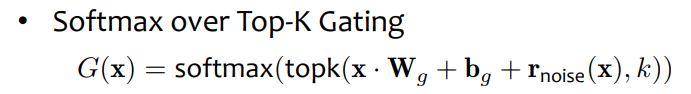  
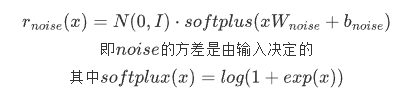
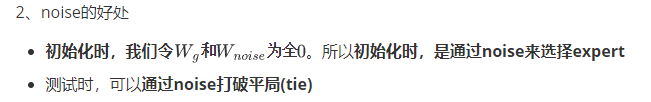

In [14]:
class SparseMMoE(nn.Module):
    """Call a Sparsely gated mixture of experts layer
    Args:
    input_size: integer - size of the input
    output_size: integer - size of the input
    num_experts: an integer - number of experts
    hidden_size: an integer - hidden size of the experts
    noisy_gating: a boolean
    k: an integer - how many experts to use for each batch element
    """

    def __init__(self, input_size, output_size, num_experts, expert_dropout=0.1, noisy_gating=True, k=2):
        super(SparseMMoE, self).__init__()
        self.noisy_gating = noisy_gating  # 在gate权重上加入噪音, 可以打破平局时的均衡
        self.num_experts = num_experts
        self.input_size = input_size
        self.output_size = output_size
        self.expert_dropout=expert_dropout
        self.k = k
        self.experts = nn.ModuleList(
            [Expert(self.input_size, self.output_size, self.expert_dropout) for i in range(self.num_experts)])
        # 将w_gate和w_noise全部初始化为全0，保证初始时通过noise选择expert
        self.w_gate = nn.Parameter(torch.zeros(input_size, num_experts), requires_grad=True)
        self.b_gate = nn.Parameter(torch.zeros(num_experts), requires_grad=True)
        self.w_noise = nn.Parameter(torch.zeros(input_size, num_experts), requires_grad=True)
        self.b_noise = nn.Parameter(torch.zeros(num_experts), requires_grad=True)

        self.softplus = nn.Softplus()
        self.softmax = nn.Softmax(dim=1)
        self.normal=Normal(0.0,1.0)
        assert (self.k <= self.num_experts)

    # cv即coefficient of variation(变异系数), cv(x)**2 = x的方差/(x的均值**2)
    # 计算cv_squared是为了计算load balancing loss
    # 参考 https://arxiv.org/pdf/1701.06538
    def cv_squared(self, x):
        """
        The squared coefficient of variation of a sample.
        Useful as a loss to encourage a positive distribution to be more uniform.
        Epsilons added for numerical stability.
        Returns 0 for an empty Tensor.
        """
        eps = 1e-10
        # if num_experts = 1
        if x.shape[0] == 1:
            return torch.tensor([0], device=x.device, dtype=x.dtype)

        return x.var() / (x.mean() ** 2 + eps)

    def gates_to_load(self, gates):
        """
        计算每个expert的真实负载，即接收了多少个样本(或者说在小批次数据内有多少个样本在该expert上的权重大于0)
        """
        return (gates > 0).sum(dim=0)

    def prob_in_top_k(self, clean_values, noisy_values, noise_stddev):
        """
        Computes the probability that value is in top k, given different random noise.
        Args:
        clean_values: a `Tensor` of shape [batch, num_epxerts].
        noisy_values: a `Tensor` of shape [batch, num_epxerts].  Equal to clean values plus
          normally distributed noise with standard deviation noise_stddev.
        noise_stddev: a `Tensor` of shape [batch, num_epxerts]
        Returns:
        a `Tensor` of shape [batch, num_epxerts].
        """

        noisy_topk_values, _ = torch.topk(noisy_values, self.k + 1)

        top_k_plus_1_values = noisy_topk_values[:, [-1]]
        prob_topk = self.normal.cdf((clean_values - top_k_plus_1_values) / noise_stddev)
        top_k_values = noisy_topk_values[:, [-2]]
        prob_after_topk = self.normal.cdf((clean_values - top_k_values) / noise_stddev)

        # 如果比top_k_plus_1_values大，就说明在topk内
        in_topk = torch.gt(noisy_values, top_k_plus_1_values)

        # 对于前k大值，除自身以外的第k大值就是第k+1大值，所以选择prob_topk
        # 对于非topk的值，除自身以外的第k大值就是第k大值，所以选择prob_after_topk
        prob = torch.where(in_topk, prob_topk, prob_after_topk)

        return prob

    def noisy_top_k_gating(self, x, train, noise_epsilon=1e-2):
        """
          Args:
            x: input Tensor with shape [batch_size, input_size]
            train: a boolean - we only add noise at training time.
            noise_epsilon: a float
          Returns:
            gates: a Tensor with shape [batch_size, num_experts]
            load: a Tensor with shape [num_experts]
        """
        clean_logits = x @ self.w_gate + self.b_gate
        if self.noisy_gating and train:
            raw_noise_stddev = x @ self.w_noise + self.b_noise
            noise_stddev = self.softplus(raw_noise_stddev) + noise_epsilon  # 为了数值稳定
            noisy_logits = clean_logits + (torch.randn_like(clean_logits) * noise_stddev)
            logits = noisy_logits
        else:
            logits = clean_logits

        # calculate topk + 1 that will be needed for the noisy gates
        top_k_logits, top_k_indices = logits.topk(self.k, dim=1)
        top_k_gates = self.softmax(top_k_logits)

        zeros = torch.zeros_like(logits, requires_grad=True)
        gates = zeros.scatter(1, top_k_indices, top_k_gates)

        if self.noisy_gating and self.k < self.num_experts and train:
            # 这里的load_i指的是第i个expert被batch内各样本激活概率的和
            load = (self.prob_in_top_k(clean_logits, noisy_logits, noise_stddev)).sum(0)
        else:
            # 这里的load是真实负载
            load = self.gates_to_load(gates)
        return gates, load

    def forward(self, x, loss_coef=1e-2):
        gates, load = self.noisy_top_k_gating(x, self.training)
        # calculate importance loss
        importance = gates.sum(0)
        # load_balancing_loss = importance_loss + load_loss
        loss = self.cv_squared(importance) + self.cv_squared(load)
        loss *= loss_coef

        dispatcher = Dispatcher(self.num_experts, gates)
        expert_inputs = dispatcher.dispatch(x)
        # gates = dispatcher.expert_to_gates()
        expert_outputs = [self.experts[i](expert_inputs[i]) for i in range(self.num_experts)]
        y = dispatcher.combine(expert_outputs)
        return y, loss

### noisy_top_k_gating()

In [15]:
k=2
num_experts=5
batch=2

logits=torch.rand(batch,num_experts)
logits

tensor([[0.1981, 0.7650, 0.0303, 0.9958, 0.3631],
        [0.6235, 0.0202, 0.7083, 0.6641, 0.1854]])

In [16]:
top_k_logits, top_k_indices=logits.topk(k,dim=1)
print(top_k_logits)
print(top_k_indices)

tensor([[0.9958, 0.7650],
        [0.7083, 0.6641]])
tensor([[3, 1],
        [2, 3]])


In [17]:
softmax = nn.Softmax(dim=1)

In [18]:
top_k_gates=softmax(top_k_logits)
top_k_gates

tensor([[0.5574, 0.4426],
        [0.5110, 0.4890]])

In [19]:
zeros = torch.zeros_like(logits, requires_grad=True)
zeros.shape

torch.Size([2, 5])

In [20]:
print(top_k_indices)
print(top_k_gates)
gates = zeros.scatter(1, top_k_indices, top_k_gates)
gates

tensor([[3, 1],
        [2, 3]])
tensor([[0.5574, 0.4426],
        [0.5110, 0.4890]])


tensor([[0.0000, 0.4426, 0.0000, 0.5574, 0.0000],
        [0.0000, 0.0000, 0.5110, 0.4890, 0.0000]], grad_fn=<ScatterBackward0>)

### prob_in_top_k()

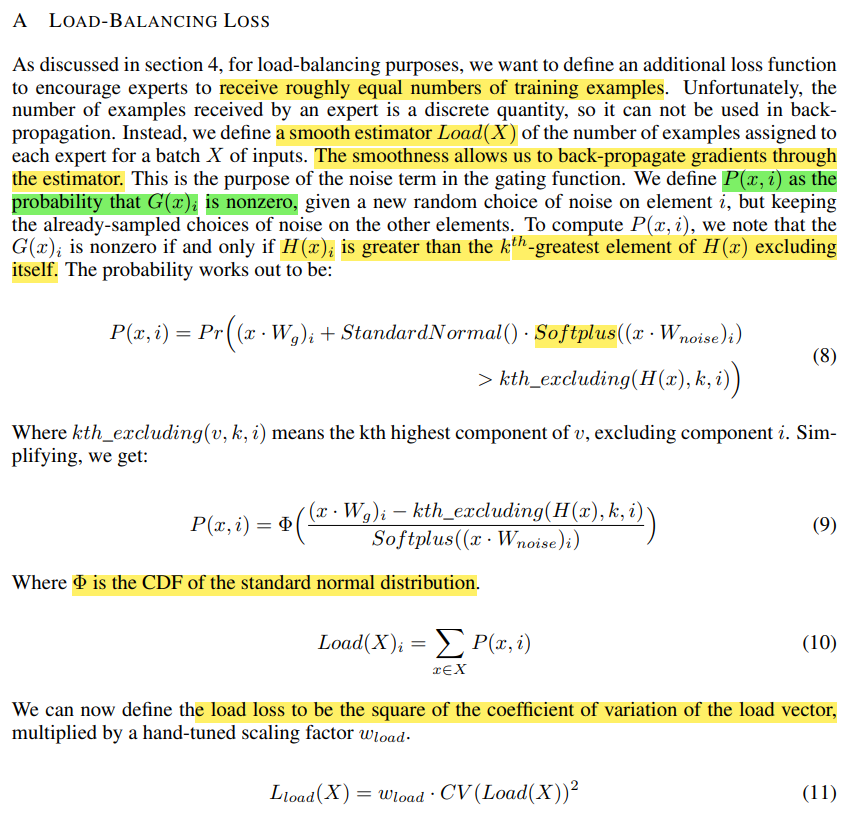

In [21]:
# prob_in_top_k()计算的就是P(x,i)
batch=2
k=2
num_experts=5
noise_stddev=0.1
normal=Normal(0,1)

clean_values=torch.rand(batch,num_experts)
print(clean_values)
noisy_values=clean_values+torch.randn_like(clean_values)*0.02
print(noisy_values)

tensor([[0.9907, 0.7945, 0.4285, 0.0087, 0.4491],
        [0.7484, 0.9419, 0.0864, 0.5593, 0.7927]])
tensor([[0.9757, 0.8230, 0.4007, 0.0333, 0.4657],
        [0.7384, 0.9293, 0.0667, 0.5515, 0.7930]])


In [22]:
noisy_topk_values, _=torch.topk(noisy_values, k+1)
print(noisy_topk_values)

tensor([[0.9757, 0.8230, 0.4657],
        [0.9293, 0.7930, 0.7384]])


In [23]:
top_k_plus_1_values=noisy_topk_values[:,[-1]]
print(top_k_plus_1_values)
prob_topk = normal.cdf((clean_values - top_k_plus_1_values)/noise_stddev)
prob_topk

tensor([[0.4657],
        [0.7384]])


tensor([[1.0000e+00, 9.9950e-01, 3.5498e-01, 2.4438e-06, 4.3441e-01],
        [5.3982e-01, 9.7906e-01, 0.0000e+00, 3.6697e-02, 7.0657e-01]])

In [24]:
top_k_values=noisy_topk_values[:,[-2]]
print(top_k_values)
prob_after_topk = normal.cdf((clean_values - top_k_values)/noise_stddev)
prob_after_topk

tensor([[0.8230],
        [0.7930]])


tensor([[9.5328e-01, 3.8782e-01, 3.9876e-05, 0.0000e+00, 9.2566e-05],
        [3.2766e-01, 9.3167e-01, 0.0000e+00, 9.7265e-03, 4.9881e-01]])

In [25]:
# 如果比top_k_plus_1_values大，就说明在topk内
in_topk = torch.gt(noisy_values, top_k_plus_1_values)
print(in_topk)
# 对于前k大值，除自身以外的第k大值就是第k+1大值，所以选择prob_topk
# 对于非topk的值，除自身以外的第k大值就是第k大值，所以选择prob_after_topk
prob=torch.where(in_topk, prob_topk, prob_after_topk)
prob

tensor([[ True,  True, False, False, False],
        [False,  True, False, False,  True]])


tensor([[1.0000e+00, 9.9950e-01, 3.9876e-05, 0.0000e+00, 9.2566e-05],
        [3.2766e-01, 9.7906e-01, 0.0000e+00, 9.7265e-03, 7.0657e-01]])

In [26]:
sparse_mmoe=SparseMMoE(5,5,5,k=2)
sparse_mmoe.prob_in_top_k(clean_values, noisy_values, noise_stddev)

tensor([[1.0000e+00, 9.9950e-01, 3.9876e-05, 0.0000e+00, 9.2566e-05],
        [3.2766e-01, 9.7906e-01, 0.0000e+00, 9.7265e-03, 7.0657e-01]])